In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

In [2]:
# Solution to import from another directory
import sys
import os

# Ignoring system gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path+"\\data")

print(sys.path)

['C:\\Users\\shash\\Anaconda3\\envs\\sentiment_analysis\\python36.zip', 'C:\\Users\\shash\\Anaconda3\\envs\\sentiment_analysis\\DLLs', 'C:\\Users\\shash\\Anaconda3\\envs\\sentiment_analysis\\lib', 'C:\\Users\\shash\\Anaconda3\\envs\\sentiment_analysis', '', 'C:\\Users\\shash\\Anaconda3\\envs\\sentiment_analysis\\lib\\site-packages', 'C:\\Users\\shash\\Downloads\\Sentiment-Analysis-with-RNN-and-LSTM\\setup.py', 'c:\\users\\shash\\downloads\\sentiment-analysis-with-rnn-and-lstm', 'C:\\Users\\shash\\Anaconda3\\envs\\sentiment_analysis\\lib\\site-packages\\win32', 'C:\\Users\\shash\\Anaconda3\\envs\\sentiment_analysis\\lib\\site-packages\\win32\\lib', 'C:\\Users\\shash\\Anaconda3\\envs\\sentiment_analysis\\lib\\site-packages\\Pythonwin', 'C:\\Users\\shash\\Anaconda3\\envs\\sentiment_analysis\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\shash\\.ipython', 'C:\\Users\\shash\\Downloads\\Sentiment-Analysis-with-RNN-and-LSTM\\data']


In [3]:
os.chdir(module_path)
tweets = pd.read_csv('data/tweets_improved.csv')

# Let's explore our data

In [4]:
tweets.head(5)

,id,created_at,sentiment,tweet
0,1282890679350439936,Tue Jul 14 04:12:27 +0000 2020,0,i think what theyre getting at though poorly c...
1,1282890574383677441,Tue Jul 14 04:12:02 +0000 2020,0,climate change is importantwe know thatbut we ...
2,1282890565592416256,Tue Jul 14 04:12:00 +0000 2020,0,how to green the worlds deserts and reverse cl...
3,1282890564703313921,Tue Jul 14 04:12:00 +0000 2020,0,minigrids could help take on climatechange wh...
4,1282890534634156032,Tue Jul 14 04:11:53 +0000 2020,1,and antique representative hosts the show and...


In [5]:
tweets.describe()

,id,sentiment
count,3.097000e+04,30970.000000
mean,1.282756e+18,0.497966
std,1.597473e+14,0.500004
min,1.282329e+18,0.000000
25%,1.282691e+18,0.000000
50%,1.282811e+18,0.000000
75%,1.282888e+18,1.000000
max,1.282897e+18,1.000000


In [6]:
tweets['sentiment'].value_counts()

0    15548
1    15422
Name: sentiment, dtype: int64

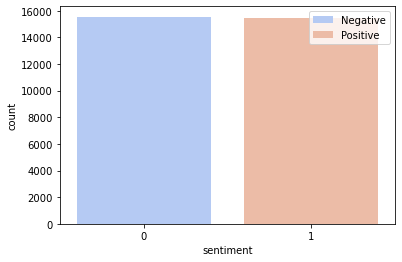

In [7]:
# Count of positive and negative tweets
chart = sns.countplot(x='sentiment',data=tweets, palette='coolwarm', hue='sentiment', dodge=False)
plt.legend(loc='best', labels=['Negative', 'Positive'])
plt.show(chart)

In [8]:
# Storing tokenized tweet and number of words in each tweet 
tweets['tweet_list'] = tweets['tweet'].apply(lambda x:str(x).split())
tweets['num_of_words'] = tweets['tweet'].apply(lambda x:len(str(x).split()))

In [9]:
# Create vocabulary
vocab_counter = Counter([item for sublist in tweets['tweet_list'] for item in sublist])
vocab = list(vocab_counter.keys())

# Looking up top 20 words by word count
temp = pd.DataFrame(vocab_counter.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,25433
1,to,20727
2,and,16203
3,a,13508
4,climate,13021
5,i,12728
6,of,12627
7,change,12521
8,is,10270
9,in,9500


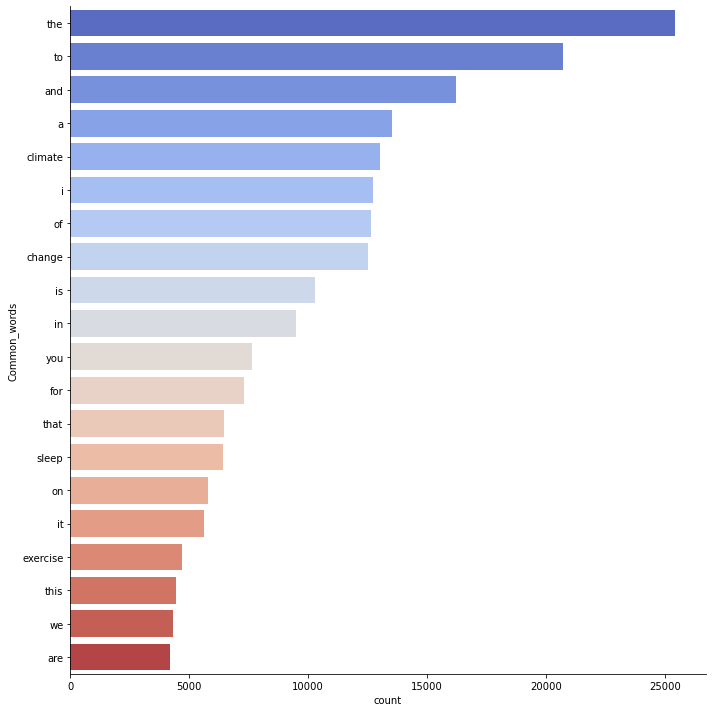

In [250]:
sns.catplot(x='count', y='Common_words',data=temp, palette='coolwarm', kind='bar', height=10, aspect=1, dodge=False)
plt.savefig('notebook/img/word_dist_600dpi.png', dpi=600, bbox_inches='tight')

In [11]:
# Maximum number of words in a tweet in our dataset
tweets['num_of_words'].describe()

count    30970.000000
mean        23.007201
std         14.308707
min          1.000000
25%         11.000000
50%         20.000000
75%         35.000000
max         63.000000
Name: num_of_words, dtype: float64

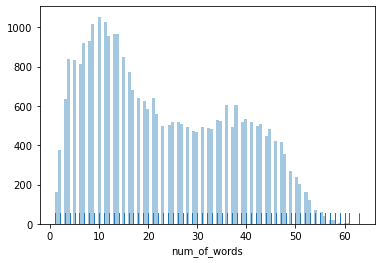

In [249]:
sb =sns.distplot(tweets['num_of_words'], bins=100, kde=False, rug=True);
plt.savefig('notebook/img/word_dist_300dpi.png', dpi=300, bbox_inches='tight')

# Model

In [235]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


max_features = 70
embedding_dim = 50
embeding_path = f"data/word_embedding/glove.twitter.27B.{embedding_dim}d.txt"

In [14]:
def get_word_embedding_dictionary():
    """ creates word_to_vector, word_to_index and index_to_word dictionaries """
    with open(embeding_path, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        skip_count = 0
        
        # Extracting word and its vectors
        for line in f:
            line_list = line.split()
            
            # Ignoring unresolvable words
            if len(line_list)!=embedding_dim+1:
                skip_count +=1
                continue
            curr_word = line_list[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line_list[1:], dtype=np.float64)
            
        word_to_index = {}
        index_to_word = {}
        for i,w in enumerate(sorted(words)):
            word_to_index[w] = i
            index_to_word[i] = w
    return word_to_index, index_to_word, word_to_vec_map

In [15]:
word_to_index, index_to_word, word_to_vec_map = get_word_embedding_dictionary()
print(word_to_vec_map['rt'])

[ 0.68243    0.73589    0.017529  -0.13763    0.36029    0.51704
  0.1954     0.75219    0.43029    1.0728     0.05725    0.60043
 -2.4946     0.032148  -0.44991    0.0097306 -0.013653  -0.51001
  0.25079   -0.34493    0.33606   -0.0096185 -0.51301    0.1276
  0.85964   -0.78568   -0.1914    -0.0033234  0.89442    0.39503
 -0.95075    0.93803   -0.31701    0.56457    1.0153     0.86391
 -0.19971    0.47159   -0.26864    0.12548   -2.749     -0.55106
  0.040409   0.29164   -0.28792   -0.02274   -0.40295    0.14771
  0.080503  -0.68115  ]


In [7]:
def sentence_to_avg(text, word_to_vec_map):
    
    word_list = text.lower().split()   
    word_list_len = len(word_list)   
    
    # Embedding array
    emb_arr = np.zeros((embedding_dim,word_list_len))    
    
    for i,word in enumerate(word_list):
        emb_arr[:,i] = word_to_vec_map[word]
    
    # Averaging the embeddings across columns
    average = np.mean(emb_arr, axis=1) 
    
    return average

In [ ]:
avg = sentence_to_avg('text jinni', word_to_vec_map)
print(avg)

In [16]:
def sentences_to_indices(X, word_to_index, max_len):    
    m = X.shape[0]                                   
    
    X_indices = np.zeros((m,max_len))
    
    # Assign indices to words
    for i,sentence in enumerate(X):        
        sentence_words = sentence.lower().split()
        sentence_words = sentence_words[:max_len]
        for j,word in enumerate(sentence_words):
            X_indices[i, j] = word_to_index.get(word,0)
    return X_indices

In [17]:
X1 = np.array(["funny lol spug", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 1)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)
print(word_to_index.get('funny'))

X1 = ['funny lol spug' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[217641.]
 [339235.]
 [211510.]]
217641


In [18]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    # Adding 1 to fit Keras embedding (requirement)
    vocab_len = len(word_to_index) + 1                  

    emb_matrix = np.zeros((vocab_len,embedding_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = layers.Embedding(
                        vocab_len,
                        embedding_dim,
                        trainable = False
                        )


    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [192]:
def sentiment_model(input_shape, word_to_vec_map, word_to_index):
    # Define sentence_indices as the input of the graph.
    sentence_indices =layers.Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    

    embeddings = embedding_layer(sentence_indices)   
    x = layers.LSTM(50, return_sequences=True)(embeddings)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(50)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
#     x = layers.Dense(2, activation='relu')(x)
#     x = layers.BatchNormalization()(x)
    predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)
    
    # Create Model instance which converts sentence_indices into X.
    model = keras.Model(inputs=sentence_indices,outputs=predictions)
    
    
    return model

In [193]:
model = sentiment_model((max_features,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 70)]              0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 70, 50)            59675700  
_________________________________________________________________
lstm_41 (LSTM)               (None, 70, 50)            20200     
_________________________________________________________________
dropout_41 (Dropout)         (None, 70, 50)            0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 70, 50)            200       
_________________________________________________________________
lstm_42 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_42 (Dropout)         (None, 50)                0  

# Creating training set

In [34]:
X_train = tweets['tweet']
Y_train = tweets['sentiment']

In [22]:
tweets_test = pd.read_csv('data/tweets_test.csv')

In [23]:
# X_test, Y_test = tweets_test['tweet'], tweets_test['sentiment']

In [24]:
X_val, X_test, Y_val, Y_test = train_test_split(tweets_test['tweet'],tweets_test['sentiment'], test_size = 0.50, random_state = 1)

In [25]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(30970,) (30970,)
(4197,) (4197,)
(4198,) (4198,)


In [26]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_features)
Y_train_OH = to_categorical(Y_train)
X_val_indices = sentences_to_indices(X_val, word_to_index, max_features)

In [245]:
print(X_train_indices[5])

[422254. 194652.  26336. 112561. 103736. 654138.  22566.  59103.   2113.
 602112.   2113. 602112. 655000. 458003. 194343. 601403. 581002. 284814.
 602198. 422254. 212206. 446381. 540291. 634268. 257482. 601149.   2113.
 602112.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.]


In [194]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs")
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc_callback = keras.callbacks.ModelCheckpoint('model/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [195]:
history = model.fit(X_train_indices, Y_train,
                    epochs = 40, batch_size = 32,
                    shuffle=True, callbacks=[tensorboard_callback, es_callback, mc_callback],
                   validation_data = (X_val_indices, Y_val) )

Train on 30970 samples, validate on 4197 samples
Epoch 1/40
30970/30970 [==============================] - 118s 4ms/sample - loss: 0.6766 - accuracy: 0.6121 - val_loss: 0.6046 - val_accuracy: 0.6776
Epoch 2/40
30970/30970 [==============================] - 110s 4ms/sample - loss: 0.5191 - accuracy: 0.7413 - val_loss: 0.5372 - val_accuracy: 0.7317
Epoch 3/40
30970/30970 [==============================] - 107s 3ms/sample - loss: 0.4649 - accuracy: 0.7797 - val_loss: 0.6914 - val_accuracy: 0.7012
Epoch 4/40
30970/30970 [==============================] - 104s 3ms/sample - loss: 0.4275 - accuracy: 0.8027 - val_loss: 0.5192 - val_accuracy: 0.7784
Epoch 5/40
30970/30970 [==============================] - 106s 3ms/sample - loss: 0.3951 - accuracy: 0.8212 - val_loss: 0.4659 - val_accuracy: 0.8008
Epoch 6/40
30970/30970 [==============================] - 106s 3ms/sample - loss: 0.3676 - accuracy: 0.8382 - val_loss: 0.4157 - val_accuracy: 0.8125
Epoch 7/40
30970/30970 [===========================

In [196]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_features)
Y_test_OH = to_categorical(Y_test)
loss, acc = model.evaluate(X_test_indices, Y_test)
print()
print("Test accuracy = ", acc)

4198/4198 [==============================] - 4s 954us/sample - loss: 0.6261 - accuracy: 0.8430

Test accuracy =  0.8430205


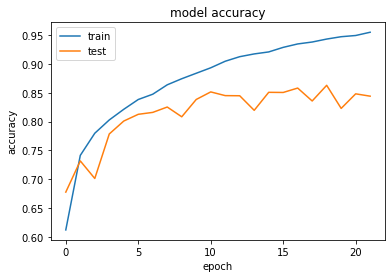

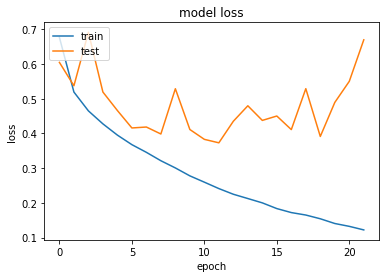

In [247]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.savefig('notebook/img/accuracy_300dpi.png', dpi=600, bbox_inches='tight')
plt.show()
# plt.savefig('plot.png', dpi=300, bbox_inches='tight')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')


# plt.savefig('notebook/loss_600dpi.png', dpi=600, bbox_inches='tight')
plt.show()

In [264]:
twt = np.array(["not good","The last thing that pandemic hit economy needs is accelerating inflation"])
twt_indices = sentences_to_indices(twt, word_to_index, max_features)
output = model.predict(twt_indices,batch_size=1,verbose = 0)[1]
output[0]
# print(sentiment)
arr = np.asarray(["not good"])
arr[0]

'not good'

In [238]:

from tensorflow.keras.models import load_model

In [240]:
best_model = load_model('model/best_model.h5')
X_test_indices = sentences_to_indices(X_test, word_to_index, max_features)
Y_test_OH = to_categorical(Y_test)
loss, acc = best_model.evaluate(X_test_indices, Y_test)
print()
print("Test accuracy = ", acc)
best_model.summary()

4198/4198 [==============================] - 6s 1ms/sample - loss: 0.3562 - accuracy: 0.8473

Test accuracy =  0.8473082
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 70)]              0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 70, 50)            59675700  
_________________________________________________________________
lstm_41 (LSTM)               (None, 70, 50)            20200     
_________________________________________________________________
dropout_41 (Dropout)         (None, 70, 50)            0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 70, 50)            200       
_________________________________________________________________
lstm_42 (LSTM)               (None, 50)                20200     
___

In [218]:
embed_layer = model.get_layer('embedding_26')
embed_layer.get_weights()

[array([[ 9.0566e-01, -7.1792e-01, -1.9574e-01, ...,  1.1230e-03,
          2.8188e-02,  3.0385e-01],
        [ 5.8560e-01, -3.6964e-01,  6.3480e-02, ...,  5.6656e-01,
         -3.6404e-01, -2.5202e-01],
        [ 4.5269e-01, -6.2509e-01,  1.6866e-01, ..., -5.0146e-01,
          2.9764e-01,  1.4548e-01],
        ...,
        [-1.0632e-01,  6.8057e-01, -1.5388e+00, ..., -4.8493e-01,
          3.2478e-01, -1.1330e-01],
        [ 7.6822e-01,  7.1786e-01,  5.8778e-01, ...,  1.6097e-01,
          8.9411e-02,  8.4237e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], dtype=float32)]

In [232]:
model.

[array([[ 9.0566e-01, -7.1792e-01, -1.9574e-01, ...,  1.1230e-03,
          2.8188e-02,  3.0385e-01],
        [ 5.8560e-01, -3.6964e-01,  6.3480e-02, ...,  5.6656e-01,
         -3.6404e-01, -2.5202e-01],
        [ 4.5269e-01, -6.2509e-01,  1.6866e-01, ..., -5.0146e-01,
          2.9764e-01,  1.4548e-01],
        ...,
        [-1.0632e-01,  6.8057e-01, -1.5388e+00, ..., -4.8493e-01,
          3.2478e-01, -1.1330e-01],
        [ 7.6822e-01,  7.1786e-01,  5.8778e-01, ...,  1.6097e-01,
          8.9411e-02,  8.4237e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], dtype=float32),
 array([[ 0.50352615, -0.4662603 , -0.28757367, ...,  0.2394619 ,
         -0.3334812 ,  0.5321654 ],
        [-0.1069283 ,  0.15848838,  0.07718259, ..., -0.12472256,
         -0.13669449,  0.28242642],
        [ 0.05579596,  0.10802864, -0.06282251, ...,  0.36504978,
         -0.09208009, -0.46714312],
        ...,
        [ 0.4176142 ,  0.49989682,  0.1

In [ ]:
# test_model = keras.Model.build()